In [1]:
import numpy as np 
import numpy as np
import matplotlib.pyplot as plt

from functionMPC import systemSimulate
from ModelPredictiveControl import ModelPredictiveControl

In [2]:
# prediction horizon
f= 15
# control horizon 
v=10

In [3]:
# masses, spring and damper constants
m1=2  ; m2=2   ; k1=100  ; k2=200 ; d1=1  ; d2=5; 
# define the continuous-time system matrices
Ac=np.matrix([[0, 1, 0, 0],
              [-(k1+k2)/m1 ,  -(d1+d2)/m1 , k2/m1 , d2/m1 ],
              [0 , 0 ,  0 , 1], 
              [k2/m2,  d2/m2, -k2/m2, -d2/m2]])
Bc=np.matrix([[0],[0],[0],[1/m2]])
Cc=np.matrix([[1, 0, 0, 0]])

r=1; m=1 # number of inputs and outputs
n= 4 # state dimension

In [4]:
class ModelPredictiveControl(object):
    
    # A,B,C - system matrices
    # f -  prediction horizon
    # v  - control horizon
    # W3 - input weight matrix
    # W4 - prediction weight matrix
    # x0 - initial state of the system
    # desiredControlTrajectoryTotal - total desired control trajectory
    #                               later on, we will take segments of this
    #                               desired state trajectory
    
    def __init__(self,A,B,C,f,v,W3,W4,x0,desiredControlTrajectoryTotal):
        
        # initialize variables
        self.A=A 
        self.B=B
        self.C=C
        self.f=f
        self.v=v
        self.W3=W3 
        self.W4=W4
        self.desiredControlTrajectoryTotal=desiredControlTrajectoryTotal
        
        # dimensions of the matrices
        
        self.n=A.shape[0]
        self.r=C.shape[0]
        self.m=B.shape[1]        
                
               
        # this variable is used to track the current time step k of the controller
        # after every calculation of the control inpu, this variables is incremented for +1 
        self.currentTimeStep=0
        
        # we store the state vectors of the controlled state trajectory
        self.states=[]
        self.states.append(x0)
        
        # we store the computed inputs 
        self.inputs=[]
        
        # we store the output vectors of the controlled state trajectory
        self.outputs=[]
        
        
        # form the lifted system matrices and vectors
        # the gain matrix is used to compute the solution 
        # here we pre-compute it to save computational time
        self.O, self.M, self.gainMatrix = self.formLiftedMatrices()
        
    
    # this function forms the lifted matrices O and M, as well as the 
    # the gain matrix of the control algorithm
    # and returns them 
    def formLiftedMatrices(self):
        f=self.f
        v=self.v
        r=self.r
        n=self.n
        m=self.m
        A=self.A
        B=self.B
        C=self.C
        
        # lifted matrix O
        O=np.zeros(shape=(f*r,n))

        for i in range(f):
            if (i == 0):
                powA=A;
            else:
                powA=np.matmul(powA,A)
            O[i*r:(i+1)*r,:]=np.matmul(C,powA)

        # lifted matrix M        
        M=np.zeros(shape=(f*r,v*m))
    
        for i in range(f):
            # until the control horizon
            if (i<v):
                for j in range(i+1):
                    if (j == 0):
                        powA=np.eye(n,n);
                    else:
                        powA=np.matmul(powA,A)
                    M[i*r:(i+1)*r,(i-j)*m:(i-j+1)*m]=np.matmul(C,np.matmul(powA,B))
            
            # from control horizon until the prediction horizon
            else:
                for j in range(v):
                    # here we form the last entry
                    if j==0:
                        sumLast=np.zeros(shape=(n,n))
                        for s in range(i-v+2):
                            if (s == 0):
                                powA=np.eye(n,n);
                            else:
                                powA=np.matmul(powA,A)
                            sumLast=sumLast+powA
                        M[i*r:(i+1)*r,(v-1)*m:(v)*m]=np.matmul(C,np.matmul(sumLast,B))
                    else:
                        powA=np.matmul(powA,A)
                        M[i*r:(i+1)*r,(v-1-j)*m:(v-j)*m]=np.matmul(C,np.matmul(powA,B))
        
        
        tmp1=np.matmul(M.T,np.matmul(self.W4,M))
        tmp2=np.linalg.inv(tmp1+self.W3)
        gainMatrix=np.matmul(tmp2,np.matmul(M.T,self.W4))
        
        
        return O,M,gainMatrix
    
    # this function propagates the dynamics
    # x_{k+1}=Ax_{k}+Bu_{k}
    
    def propagateDynamics(self,controlInput,state):

        xkp1=np.zeros(shape=(self.n,1))
        yk=np.zeros(shape=(self.r,1))
        xkp1=np.matmul(self.A,state)+np.matmul(self.B,controlInput)
        yk=np.matmul(self.C,state)
        
        return xkp1,yk
        
    # this function computes the control inputs, applies them to the system 
    # by calling the propagateDynamics() function and appends the lists
    # that store the inputs, outputs, states
    def computeControlInputs(self):
                
        # extract the segment of the desired control trajectory
        desiredControlTrajectory=self.desiredControlTrajectoryTotal[self.currentTimeStep:self.currentTimeStep+self.f,:]

        # compute the vector s
        vectorS=desiredControlTrajectory-np.matmul(self.O,self.states[self.currentTimeStep])
       
        # compute the control sequence
        inputSequenceComputed=np.matmul(self.gainMatrix,vectorS)
        inputApplied=np.zeros(shape=(1,1))
        inputApplied[0,0]=inputSequenceComputed[0,0]
        
        # compute the next state and output
        state_kp1,output_k=self.propagateDynamics(inputApplied,self.states[self.currentTimeStep])
        
        # append the lists
        self.states.append(state_kp1)
        self.outputs.append(output_k)
        self.inputs.append(inputApplied)
        # increment the time step
        self.currentTimeStep=self.currentTimeStep+1

In [5]:
def systemSimulate(A,B,C,U,x0):
    import numpy as np
    simTime=U.shape[1]
    n=A.shape[0]
    r=C.shape[0]
    X=np.zeros(shape=(n,simTime+1))
    Y=np.zeros(shape=(r,simTime))
    for i in range(0,simTime):
        if i==0:
            X[:,[i]]=x0
            Y[:,[i]]=np.matmul(C,x0)
            X[:,[i+1]]=np.matmul(A,x0)+np.matmul(B,U[:,[i]])
        else:
            Y[:,[i]]=np.matmul(C,X[:,[i]])
            X[:,[i+1]]=np.matmul(A,X[:,[i]])+np.matmul(B,U[:,[i]])
    
    return Y,X

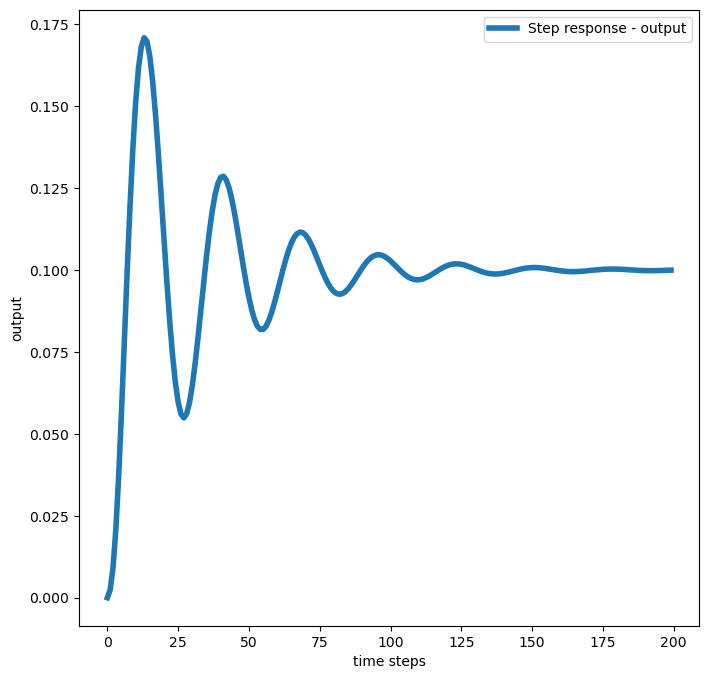

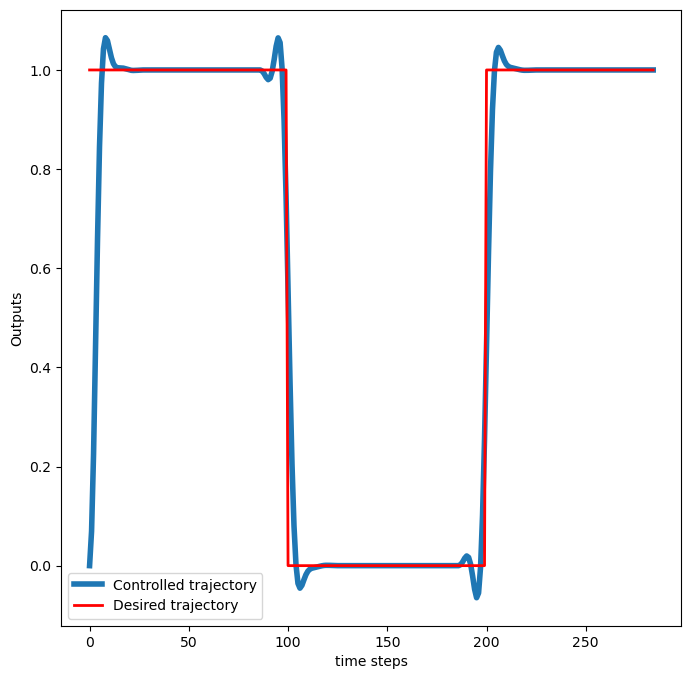

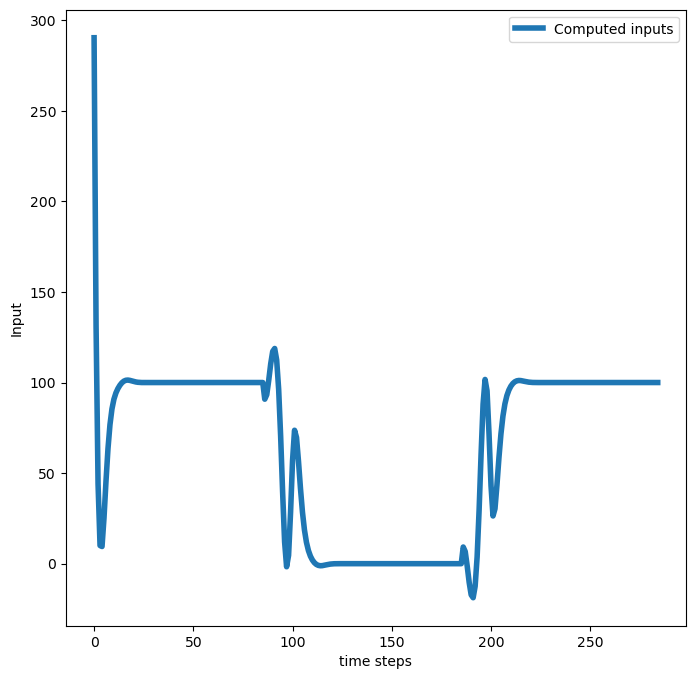

In [6]:
###############################################################################
# discretize and simulate the system step response
###############################################################################

# discretization constant
sampling=0.05

# model discretization
I=np.identity(Ac.shape[0]) # this is an identity matrix
A=np.linalg.inv(I-sampling*Ac)
B=A*sampling*Bc
C=Cc

# check the eigenvalues
eigen_A=np.linalg.eig(Ac)[0]
eigen_Aid=np.linalg.eig(A)[0]

timeSampleTest=200

# compute the system's step response
inputTest=10*np.ones((1,timeSampleTest))
x0test=np.zeros(shape=(4,1))


# simulate the discrete-time system 
Ytest, Xtest=systemSimulate(A,B,C,inputTest,x0test)


plt.figure(figsize=(8,8))
plt.plot(Ytest[0,:],linewidth=4, label='Step response - output')
plt.xlabel('time steps')
plt.ylabel('output')
plt.legend()
plt.savefig('stepResponse.png',dpi=600)
plt.show()

###############################################################################
# end of step response
###############################################################################

###############################################################################
# form the weighting matrices
###############################################################################

# W1 matrix
W1=np.zeros(shape=(v*m,v*m))

for i in range(v):
    if (i==0):
        W1[i*m:(i+1)*m,i*m:(i+1)*m]=np.eye(m,m)
    else:
        W1[i*m:(i+1)*m,i*m:(i+1)*m]=np.eye(m,m)
        W1[i*m:(i+1)*m,(i-1)*m:(i)*m]=-np.eye(m,m)

# W2 matrix
Q0=0.0000000011
Qother=0.0001

W2=np.zeros(shape=(v*m,v*m))

for i in range(v):
    if (i==0):
        W2[i*m:(i+1)*m,i*m:(i+1)*m]=Q0
    else:
        W2[i*m:(i+1)*m,i*m:(i+1)*m]=Qother

# W3 matrix        
W3=np.matmul(W1.T,np.matmul(W2,W1))

# W4 matrix
W4=np.zeros(shape=(f*r,f*r))

# in the general case, this constant should be a matrix
predWeight=10

for i in range(f):
    W4[i*r:(i+1)*r,i*r:(i+1)*r]=predWeight
###############################################################################
# end of step response
###############################################################################

###############################################################################
# Define the reference trajectory 
###############################################################################

timeSteps=300

# here you need to comment/uncomment the trajectory that you want to use

# exponential trajectory
# timeVector=np.linspace(0,100,timeSteps)
#desiredTrajectory=np.ones(timeSteps)-np.exp(-0.01*timeVector)
#desiredTrajectory=np.reshape(desiredTrajectory,(timeSteps,1))

# pulse trajectory
desiredTrajectory=np.zeros(shape=(timeSteps,1))
desiredTrajectory[0:100,:]=np.ones((100,1))
desiredTrajectory[200:,:]=np.ones((100,1))

# step trajectory

#desiredTrajectory=0.3*np.ones(shape=(timeSteps,1))

###############################################################################
# end of definition of the reference trajectory 
###############################################################################

###############################################################################
# Simulate the MPC algorithm and plot the results
###############################################################################

# set the initial state
x0=x0test

# create the MPC object

mpc=ModelPredictiveControl(A,B,C,f,v,W3,W4,x0,desiredTrajectory)

# simulate the controller

for i in range(timeSteps-f):
    mpc.computeControlInputs()
    
    

# extract the state estimates in order to plot the results
desiredTrajectoryList=[]
controlledTrajectoryList=[]
controlInputList=[]
for j in np.arange(timeSteps-f):
    controlledTrajectoryList.append(mpc.outputs[j][0,0])
    desiredTrajectoryList.append(desiredTrajectory[j,0])
    controlInputList.append(mpc.inputs[j][0,0])

# plot the results
    
plt.figure(figsize=(8,8))
plt.plot(controlledTrajectoryList,linewidth=4, label='Controlled trajectory')
plt.plot(desiredTrajectoryList,'r', linewidth=2, label='Desired trajectory')
plt.xlabel('time steps')
plt.ylabel('Outputs')
plt.legend()
plt.savefig('controlledOutputsPulse.png',dpi=600)
plt.show()


plt.figure(figsize=(8,8))
plt.plot(controlInputList,linewidth=4, label='Computed inputs')
plt.xlabel('time steps')
plt.ylabel('Input')
plt.legend()
plt.savefig('inputsPulse.png',dpi=600)
plt.show()